In [1]:
'''
Is the movie industry dying? is Netflix the new entertainment king? 
Those were the first questions that lead me to create a dataset focused on movie revenue and analyze it over the last decades. 
But, why stop there? There are more factors that intervene in this kind of thing, like actors, genres, user ratings and more. 
And now, anyone with experience (you) can ask specific questions about the movie industry, and get answers.
'''
%reset

In [2]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action='once')

In [3]:
data_raw = pd.read_csv('movies_fixed.csv')
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
budget      6820 non-null float64
company     6820 non-null object
country     6820 non-null object
director    6820 non-null object
genre       6820 non-null object
gross       6820 non-null float64
name        6820 non-null object
rating      6820 non-null object
released    6820 non-null object
runtime     6820 non-null int64
score       6820 non-null float64
star        6820 non-null object
votes       6820 non-null int64
writer      6820 non-null object
year        6820 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


### Data preprocessing

In [4]:
def get_column_types(df):
    quantitative = list(df._get_numeric_data().columns)
    qualitative = [c for c in list(df.columns) if c not in quantitative]
    return qualitative, quantitative

def data_preparation_for_model(df, qualitative, target):
    result = df.copy()
    to_drop = [target, 'name', 'released', 'votes']
    for_one_hot_encoding = [i for i in qualitative if i not in to_drop]
    result.drop(to_drop, axis=1, inplace=True)
    result = pd.get_dummies(data=result, columns=for_one_hot_encoding)
    result[target] = df[target]  # Return back target variable.
    return result

def feature_selection_for_model(df, objective, target, top_features=None):
    X = df.drop(target, axis=1).copy()
    y = df[target].copy()
    
    if objective == 'regression':
        estimator = ExtraTreesRegressor()
    elif objective == 'classification':
        estimator = ExtraTreesClassifier()
        
    estimator = estimator.fit(X, y)
    model = SelectFromModel(estimator, prefit=True)
    no_important_features = model.transform(X).shape[1]
    
    if top_features:
        to_features_to_pass = top_features
    else:
        to_features_to_pass = no_important_features
        
    important_features =pd.DataFrame({
        'feature': list(X.columns),
        'feature_importance': list(estimator.feature_importances_)
    }).sort_values(by='feature_importance', ascending=False).head(to_features_to_pass)
    return list(important_features['feature'])

def prepare_data_sets_for_model(df, important_features, target):
    train = df[important_features].copy()
    train[target] = df[target].copy()

    y = train[target]
    X = train.drop(target, axis=1)
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=12)
    return X_train, X_eval, y_train, y_eval

qualitative, quantitative = get_column_types(data_raw)

#### Prepare regression to fill 0.0 'budget'

MSE: 741651847929752.8
R2: 0.5488714525250846
CPU times: user 18.3 s, sys: 798 ms, total: 19.1 s
Wall time: 17.4 s


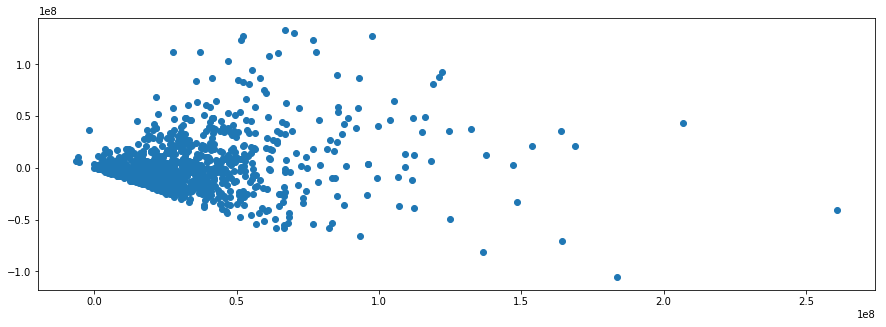

In [6]:
%%time
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
TARGET_BUDGET = 'budget'

# Model preparation.
def prepare_model_for_budget(df, important_features, target):
    X_train, X_eval, y_train, y_eval = prepare_data_sets_for_model(
        df, important_features, target)
    
    # Training.
    regressor = ElasticNet()
    regressor.fit(X_train, y_train)
    
    # Evaluation.
    prediction = regressor.predict(X_eval)
    print('MSE: {}'.format(mean_squared_error(y_eval, prediction)))
    print('R2: {}'.format(r2_score(y_eval, prediction)))
    
    plt.figure(figsize=(15,5))
    plt.scatter(prediction, y_eval - prediction)
    return regressor

# Fill function.
def fill_empty_budget(df, qualitative, target, important_features_for_budget,
                      model_for_budget, scale_min, scale_max):
    result = df.copy()
    index_to_predict = list(df[df[target] == 0.0].index)
    df = data_preparation_for_model(df, qualitative, target)
    df = df[important_features_for_budget]
    prediction = pd.Series(data=model_for_budget.predict(df.loc[index_to_predict, :]), index=index_to_predict)
    # Prediction result scaling (min-max scaler).
    prediction = pd.Series(data=minmax_scale(prediction, feature_range=(scale_min, scale_max)), index=index_to_predict)
    result.loc[index_to_predict, target] = prediction.apply(lambda x: float(int(x)))
    return result

train_raw_for_budget = data_preparation_for_model(data_raw, qualitative, TARGET_BUDGET)
# Skip rows that will be filled.
train_raw_for_budget = train_raw_for_budget[train_raw_for_budget[TARGET_BUDGET] != 0.0]
important_features_for_budget = feature_selection_for_model(
    df=train_raw_for_budget,
    objective='regression',
    target=TARGET_BUDGET)
model_for_budget = prepare_model_for_budget(train_raw_for_budget, important_features_for_budget, TARGET_BUDGET)

#### Prepare classification to fill 'rating'

In [7]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
TARGET_RATING = 'rating'
rating_to_skip = ['NOT RATED', 'UNRATED', 'Not specified']

def prepare_model_for_rating(df, important_features, target):
    X_train, X_eval, y_train, y_eval = prepare_data_sets_for_model(
    df, important_features, target)

    # Training.
    classifier = GradientBoostingClassifier()
    classifier.fit(X_train, y_train)
    
    # Evaluation.
    prediction = classifier.predict(X_eval)
    accuracy = round(accuracy_score(y_eval, prediction), 4)
    print('Accuracy score: {}%'.format(accuracy*100))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_eval, prediction))
    print('\nClassification Report:')
    print(classification_report(y_eval, prediction))
    return classifier

def fill_empty_rating(df, qualitative, target, important_features_for_rating,
                      model_for_rating, rating_to_skip):
    result = df.copy()
    index_to_predict = list(df[df[target].isin(rating_to_skip)].index)
    df = data_preparation_for_model(df, qualitative, target).copy()
    df = df[important_features_for_rating]
    prediction = pd.Series(data=model_for_rating.predict(df.loc[index_to_predict, :]), index=index_to_predict)
    result.loc[index_to_predict, target] = prediction
    return result

tain_raw_for_rating = data_preparation_for_model(data_raw, qualitative, TARGET_RATING)
# Skip rows that will be filled.
tain_raw_for_rating = tain_raw_for_rating[~tain_raw_for_rating['rating'].isin(rating_to_skip)]
important_features_for_rating = feature_selection_for_model(
    df=tain_raw_for_rating,
    objective='classification',
    target=TARGET_RATING,
    top_features=80)
model_for_rating = prepare_model_for_rating(
    df=tain_raw_for_rating,
    important_features=important_features_for_rating,
    target=TARGET_RATING)

Accuracy score: 64.85%

Confusion matrix:
[[  0   0   0   0   0   1]
 [  0  14   0  13   2   1]
 [  0   0   0   0   0   3]
 [  0   4   0  74  61  69]
 [  0   1   0  12 188 184]
 [  0   1   0   9  97 569]]

Classification Report:
             precision    recall  f1-score   support

        B15       0.00      0.00      0.00         1
          G       0.70      0.47      0.56        30
      NC-17       0.00      0.00      0.00         3
         PG       0.69      0.36      0.47       208
      PG-13       0.54      0.49      0.51       385
          R       0.69      0.84      0.76       676

avg / total       0.64      0.65      0.63      1303

CPU times: user 24.5 s, sys: 1.28 s, total: 25.8 s
Wall time: 13 s


/Users/slechwar/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Transform raw data set

In [8]:
%%time
def data_raw_transformation(data_raw):
    qualitative, quantitative = get_column_types(data_raw)
    result = data_raw.copy()
    
    # Use regression to fill 0.0's in budget.
    budget_scale_min = data_raw.loc[data_raw['budget'] != 0.0, 'budget'].min()
    budget_scale_max = data_raw.loc[data_raw['budget'] != 0.0, 'budget'].max()
    result = fill_empty_budget(
        df=result, 
        qualitative=qualitative, 
        target='budget', 
        important_features_for_budget=important_features_for_budget,
        model_for_budget=model_for_budget, 
        scale_min=budget_scale_min, 
        scale_max=budget_scale_max)
    
    # Use classification to fill "rating".
    rating_to_skip = ['NOT RATED', 'UNRATED', 'Not specified']
    result = fill_empty_rating(
        df=result,
        qualitative=qualitative,
        target='rating',
        important_features_for_rating=important_features_for_rating,
        model_for_rating=model_for_rating,
        rating_to_skip=rating_to_skip)
    
    # Buckets.
    bins = [0, 1e6, 1e7, 5e7, 1e8, 1e99]
    labels = ['tiny', 'small', 'medium', 'high', 'enormous']
       
    # Ceate bucket'ize version of budget.
    # result['budget_bin'] = pd.cut(x=result['budget'], bins=bins, labels=labels)
    
    # Create bucket'ize version of gross.
    # result['gross_bin'] = pd.cut(x=result['gross'], bins=bins, labels=labels)
    
    # Create bucket'ize version of votes.
    # result['votes_bin'] = pd.qcut(
    #     x=result['votes'], q=4, labels=['few', 'some', 'many', 'a_lot'], duplicates='drop')
    
    # Create bucket'ize version of runtime.
    # result['runtime_bin'] = pd.qcut(
    #     x=result['runtime'], q=4, labels=['short', 'normal', 'long', 'very_long'], duplicates='drop') 
    
    # Create bucket'ize version of score.
    # result['score_bin'] = pd.qcut(
    #     x=result['score'], q=4, labels=['poor', 'normal', 'good', 'very_good'], duplicates='drop') 
    
    #### ------- ADD ENCODING -------
    result_encoded = result.copy()
    # Create labeled version of released feature.
    season_map = {
        '01': 1,
        '02': 1,
        '03': 1,
        '04': 2,
        '05': 2,
        '06': 2,
        '07': 3,
        '08': 3,
        '09': 3,
        '10': 4,
        '11': 4,
        '12': 4,
    }
    result_encoded['released'] = (result_encoded['released']
                                  .apply(lambda x: x + '-01' if len(x) == 4 else x))
    result_encoded['released'] = result_encoded['released'].apply(lambda x: x[5:7])
    result_encoded['released'] = result_encoded['released'].apply(lambda x: season_map[x])
    
    # Create labeled version of rating.
    rating_map = {
        'G': 1,
        'B': 2,
        'PG': 3,
        'TV-PG': 4,
        'PG-13': 5,
        'TV-14': 6,
        'B15': 7,
        'R': 8,
        'TV-MA': 9, 
        'NC-17': 10,
    }
    result_encoded['rating'] = result_encoded['rating'].apply(lambda x: rating_map[x])
    
    # Create labeled version of genre
    genre_map = {
        'Animation': 1,
        'Fantasy': 1,
        'Family': 1,
        'Comedy': 1,
        'Romance': 2,
        'Musical': 2,
        'Biography': 2,
        'Drama': 2,
        'Sci-Fi': 3,
        'Adventure': 3,
        'Western': 4,
        'Action': 4,
        'Crime': 4,
        'War': 4,
        'Thriller': 5,
        'Mystery': 5,
        'Horror': 5,
    }
    result_encoded['genre'] = result_encoded['genre'].apply(lambda x: genre_map[x])
    
    # Simplify country.
    main_countries = ['USA', 'UK', 'France', 'Canada', 'Germany']
    result_encoded['country'] = (result_encoded['country']
                                 .apply(lambda x: x if x in main_countries else 'Other'))
    
    # Simplify year.
    year_min = result['year'].min()
    result_encoded['year'] = result_encoded['year'].apply(lambda x: x - year_min + 1)
    
    # Scaler.
    to_scale_columns = ['budget', 'gross', 'runtime', 'votes']
    for column in to_scale_columns:
        result_encoded[column] = minmax_scale(X=result_encoded[column], feature_range=(1, 5))
    
    # One hot encoding.
    one_hot_encoding_columns = ['company', 'country', 'director', 'star', 'writer']
    result_encoded = pd.get_dummies(
        data=result_encoded, columns=one_hot_encoding_columns, drop_first=True)
    
    # Remove columns.
    to_drop = ['name']
    result_encoded.drop(to_drop, axis=1, inplace=True)

    return result, result_encoded

data, data_encoded = data_raw_transformation(data_raw)

/Users/slechwar/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


CPU times: user 3.01 s, sys: 393 ms, total: 3.41 s
Wall time: 1.57 s


In [9]:
data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


### Clustering

In [10]:
%%time
# Outliers removal.
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=50)

data_encoded.loc[:,'is_inlier'] = lof.fit_predict(data_encoded)
data_encoded = data_encoded[data_encoded['is_inlier'] == 1]
data_encoded.drop('is_inlier', axis=1, inplace=True)

CPU times: user 2min 27s, sys: 1.01 s, total: 2min 28s
Wall time: 2min 26s


In [45]:
%%time
# Look for number of clusters and silhouette score.
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters: 
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_encoded)
    silhouette_avg = silhouette_score(data_encoded, cluster_labels)
    print("For n_clusters={}, average silhouette_score is : {}".format(n_clusters, silhouette_avg))
    
# Conclusion: analyze only 2 clusters.

For n_clusters=2, average silhouette_score is : 0.500684632020287
For n_clusters=3, average silhouette_score is : 0.38530065072503467
For n_clusters=4, average silhouette_score is : 0.30389749112220626
For n_clusters=5, average silhouette_score is : 0.24168327102952636
For n_clusters=6, average silhouette_score is : 0.2178399320998929
For n_clusters=7, average silhouette_score is : 0.1954915774387199
For n_clusters=8, average silhouette_score is : 0.2036718584387899
For n_clusters=9, average silhouette_score is : 0.17893803704635777
For n_clusters=10, average silhouette_score is : 0.17490575473689537
CPU times: user 17min 49s, sys: 1min 29s, total: 19min 19s
Wall time: 7min 12s


In [11]:
%%time
# Agglomerative clustering.
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
data_encoded['cluster'] = clusterer.fit_predict(data_encoded)

CPU times: user 4min 25s, sys: 1.47 s, total: 4min 27s
Wall time: 4min 29s


In [50]:
# Add cluster column to data dataset.
# If cluser not avilable, it means that it (record) was outlier.
index_with_cluster = list(data_encoded['cluster'].index)
if 'cluster' in data:
    data.drop('cluster', axis=1, inplace=True)
data.loc[index_with_cluster, 'cluster'] = data_encoded['cluster']
data.loc[np.isnan(data['cluster']), 'cluster'] = 'outlier'
cluster_map = {
    0: 'cluster_one',
    1: 'cluster_two',
    'outlier': 'outlier'
}
data['cluster'] = data['cluster'].apply(lambda x: cluster_map[x])

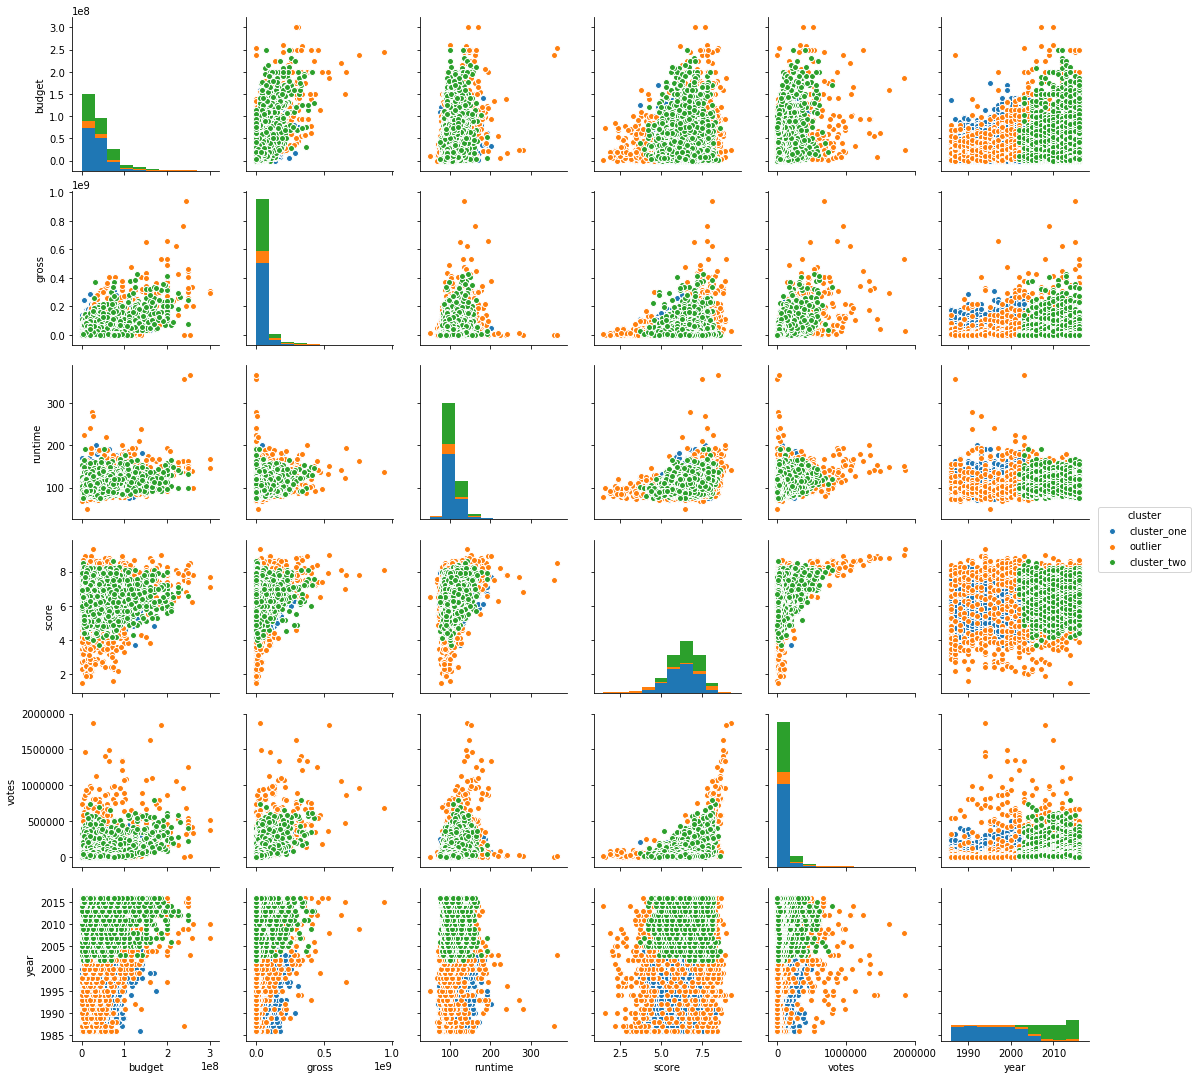

In [51]:
sns.pairplot(data=data, hue='cluster')
# Not really good clustering I would say....

## Data analysis

In [229]:
# Choose data set for analysis
analysis = data_raw
# analysis = data

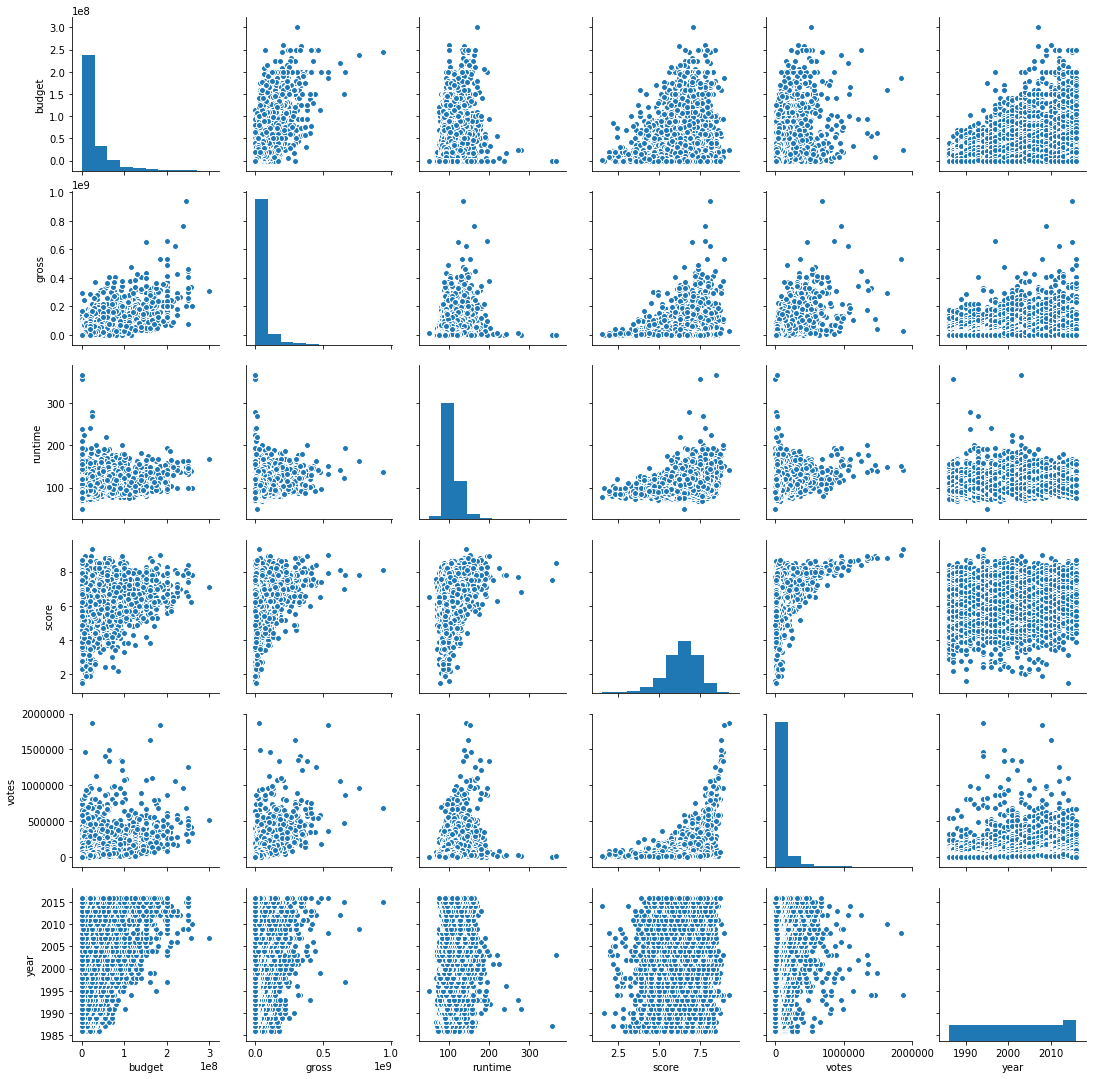

In [185]:
# Pairplot
sns.pairplot(data=analysis)

### budget

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


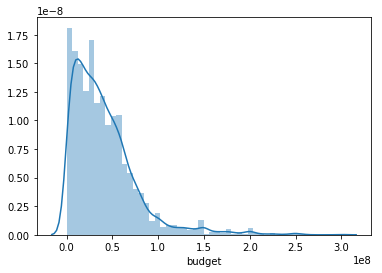

In [143]:
# sns.distplot(data_raw['budget'])
sns.distplot(analysis['budget'])

In [117]:
analysis['budget'].value_counts().head()
# We have more than 2000 zero budget movies. Is that correct? Let's check this out...

0.0           2182
20000000.0     207
30000000.0     191
25000000.0     177
15000000.0     170
Name: budget, dtype: int64

In [118]:
analysis[analysis['budget'] == 0.0].head()
# "The Name of the Rose" is for sure NOT zero budget movie, I need to treat that as unknown

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
25,0.0,TriStar Pictures,USA,John Badham,Comedy,40697761.0,Short Circuit,PG,1986-05-09,98,6.6,Ally Sheedy,47068,S.S. Wilson,1986
26,0.0,Neue Constantin Film,Italy,Jean-Jacques Annaud,Crime,7153487.0,The Name of the Rose,R,1986-09-24,130,7.8,Sean Connery,86991,Umberto Eco,1986
27,0.0,TriStar Pictures,USA,Sidney J. Furie,Action,24159872.0,Iron Eagle,PG-13,1986-01-17,117,5.3,Louis Gossett Jr.,11304,Kevin Alyn Elders,1986
32,0.0,Gaumont,France,Jean-Jacques Beineix,Drama,2003822.0,Betty Blue,Not specified,1986-11-07,120,7.4,Jean-Hugues Anglade,14562,Philippe Djian,1986
35,0.0,Columbia Pictures Corporation,USA,John G. Avildsen,Action,115103979.0,The Karate Kid Part II,PG,1986-06-20,113,5.9,Pat Morita,58370,Robert Mark Kamen,1986


In [119]:
# What was higher budget movies? Is that real?
analysis.sort_values(by='budget', ascending=False).head()
# Seems real.
# Idea for data transformation -> create bucket'ize version of variable

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
4631,300000000.0,Walt Disney Pictures,USA,Gore Verbinski,Action,309420425.0,Pirates of the Caribbean: At World's End,PG-13,2007-05-25,169,7.1,Johnny Depp,514191,Ted Elliott,2007
5293,260000000.0,Walt Disney Animation Studios,USA,Nathan Greno,Animation,200821936.0,Tangled,PG,2010-11-24,100,7.8,Mandy Moore,325621,Dan Fogelman,2010
4637,258000000.0,Columbia Pictures,USA,Sam Raimi,Action,336530303.0,Spider-Man 3,PG-13,2007-05-04,139,6.2,Tobey Maguire,416842,Sam Raimi,2007
6624,250000000.0,Marvel Studios,USA,Anthony Russo,Action,408084349.0,Captain America: Civil War,PG-13,2016-05-06,147,7.9,Chris Evans,442645,Christopher Markus,2016
6194,250000000.0,New Line Cinema,New Zealand,Peter Jackson,Adventure,255119788.0,The Hobbit: The Battle of the Five Armies,PG-13,2014-12-17,144,7.4,Ian McKellen,396797,Fran Walsh,2014


### gross

In [15]:
analysis[analysis['gross'] == 0.0]
# no 0.0's

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year


/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


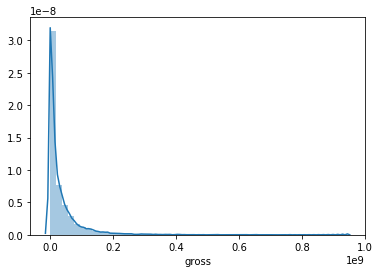

In [16]:
sns.distplot(analysis['gross'])

### comapny

In [121]:
analysis['company'].value_counts().shape

(2179,)

In [122]:
analysis['company'].value_counts().head()

Universal Pictures                        302
Warner Bros.                              294
Paramount Pictures                        259
Twentieth Century Fox Film Corporation    205
New Line Cinema                           172
Name: company, dtype: int64

### country

In [123]:
analysis['country'].value_counts().shape

(57,)

In [125]:
analysis['country'].isnull().sum()

0

In [124]:
analysis['country'].value_counts().head()

USA        4872
UK          698
France      283
Canada      150
Germany     134
Name: country, dtype: int64

In [126]:
top_5_countries = list(analysis['country'].value_counts().head(5).index)
data_raw_top_5_countries = analysis[analysis['country'].isin(top_5_countries)]

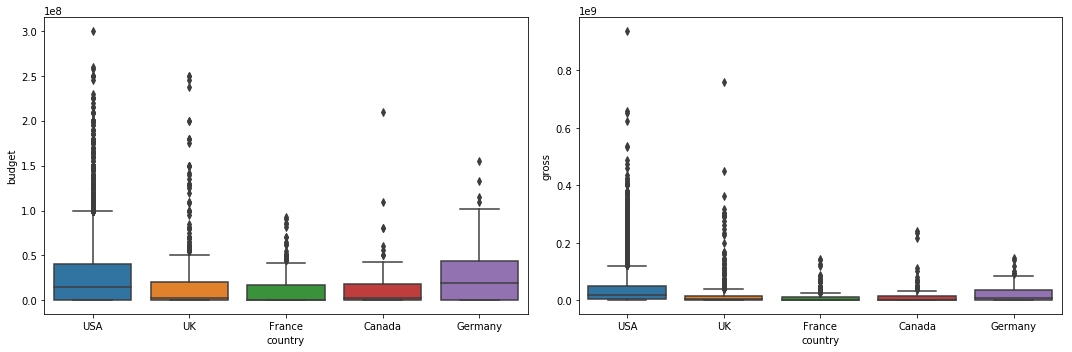

In [65]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.boxplot(x='country', y='budget', data=data_raw_top_5_countries)

plt.subplot(122)
sns.boxplot(x='country', y='gross', data=data_raw_top_5_countries)

plt.tight_layout()

### rating

In [127]:
analysis['rating'].value_counts()
# Some explainantions:
# https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system
# Seems that we got a lot "R" restricted movies.

# We have 3 types of missing data:
# NOT RATED
# UNRATED
# Not specified

R                3392
PG-13            1995
PG                951
NOT RATED         174
G                 147
UNRATED            71
Not specified      63
NC-17              22
TV-14               1
B15                 1
TV-PG               1
B                   1
TV-MA               1
Name: rating, dtype: int64

### runtime

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


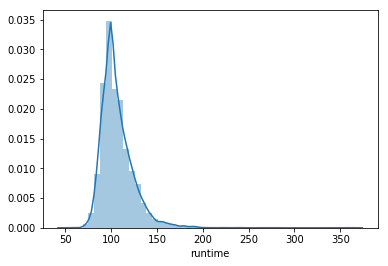

In [132]:
sns.distplot(analysis['runtime'])

### score

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


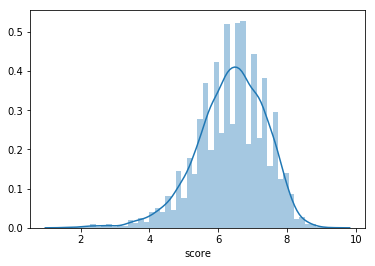

In [133]:
sns.distplot(analysis['score'])

In [142]:
analysis.sort_values(by='score', ascending=False).head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
1760,25000000.0,Castle Rock Entertainment,USA,Frank Darabont,Crime,28341469.0,The Shawshank Redemption,R,1994-10-14,142,9.3,Tim Robbins,1861666,Stephen King,1994
4840,185000000.0,Warner Bros.,USA,Christopher Nolan,Action,534858444.0,The Dark Knight,PG-13,2008-07-18,152,9.0,Christian Bale,1839571,Jonathan Nolan,2008
1542,22000000.0,Universal Pictures,USA,Steven Spielberg,Biography,96067179.0,Schindler's List,R,1994-02-04,195,8.9,Liam Neeson,956124,Thomas Keneally,1993
1761,8000000.0,Miramax,USA,Quentin Tarantino,Crime,107928762.0,Pulp Fiction,R,1994-10-14,154,8.9,John Travolta,1456787,Quentin Tarantino,1994
3743,94000000.0,New Line Cinema,USA,Peter Jackson,Adventure,377845905.0,The Lord of the Rings: The Return of the King,PG-13,2003-12-17,201,8.9,Elijah Wood,1332020,J.R.R. Tolkien,2003


### votes

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


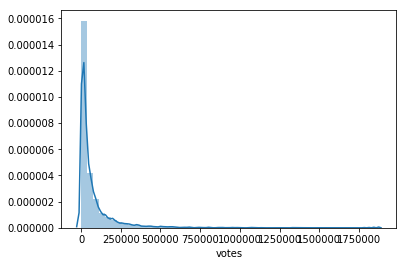

In [44]:
sns.distplot(analysis['votes'])

In [148]:
analysis['votes'].sort_values().head(10)
# We do not have missing data here.

1077     27
213     103
1093    125
1096    139
215     139
3057    146
155     154
188     156
208     163
202     171
Name: votes, dtype: int64

### star

In [149]:
analysis['star'].isnull().sum()

0

### writer

In [150]:
analysis['writer'].isnull().sum()

0

### year

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


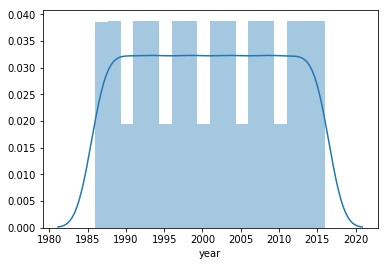

In [161]:
sns.distplot(analysis['year'])

### genre

In [234]:
analysis['genre'].value_counts()

Comedy       2080
Drama        1444
Action       1331
Crime         522
Adventure     392
Biography     359
Animation     277
Horror        277
Mystery        38
Fantasy        32
Thriller       18
Romance        15
Family         14
Sci-Fi         13
Musical         4
Western         2
War             2
Name: genre, dtype: int64